# Graph Attention Network论文笔记
> 文章地址：https://arxiv.org/pdf/1710.10903.pdf
> GitHub项目地址：https://github.com/PetarV-/GAT

本文讨论的论文是在Graph Neural Networks领域使用注意力机制的代表文章，发布在ICLR 2018会议，在Graph Neural Networks领域的一系列数据集上在当时都跑出了SOTA的成绩。本文简要记录原文章的几个关键点。

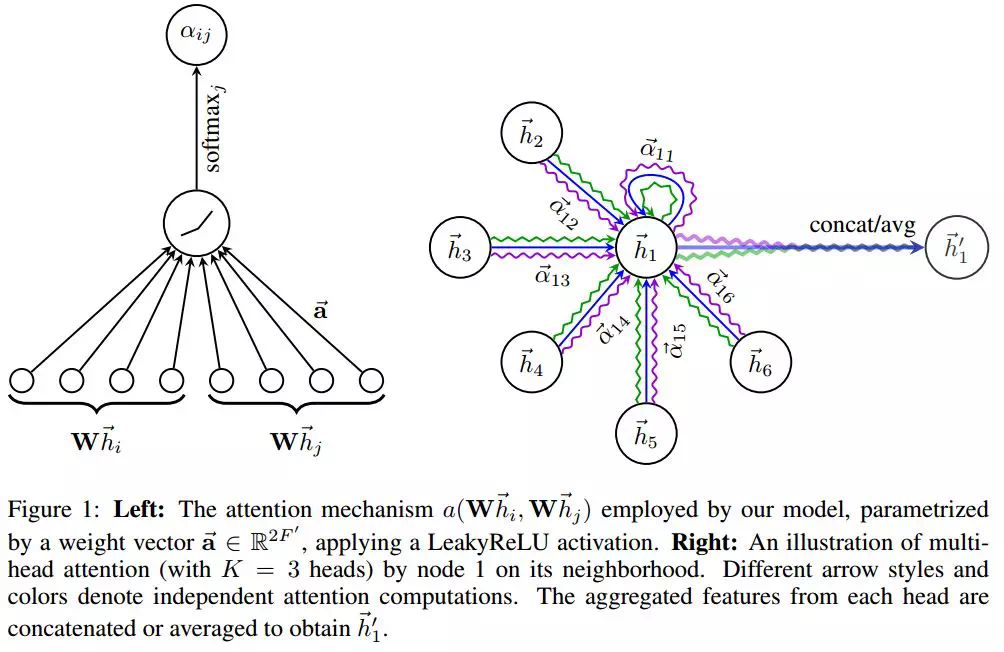

### 1、问题背景：
通常Graph Neural Networks的卷积分为谱方法和非谱方法，前者基于图的谱表达，后者直接在图上定义每个节点的卷积规则；而自主意力机制则专注于对分类其重要作用的那部分特征，具有高度并行、**不受输入向量长度限制**等特性。而作者则是将两者结合设计了新的模型用以处理图结构在深度神经网络中的问题。接下来重点记录一下文章创新的graph attention layer基础block的计算方法。

### 2、Graph Attention Layer：
整个模型的理论部分还是非常简单明了的（相较于其他的图神经网络结构），第一张插图已经高度概括了其计算方式，既先分别计算中心节点于一阶各邻域的相关性得到左图的注意力分数，计算公式如下：
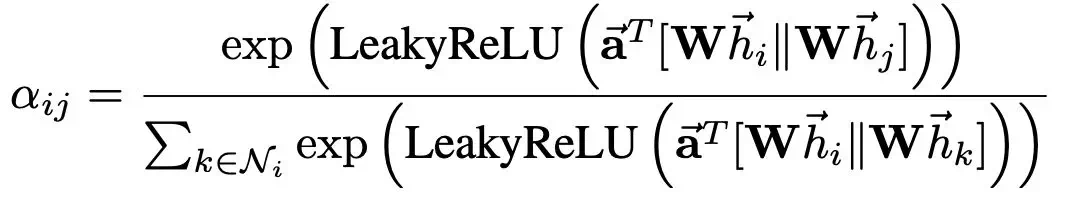

其中W为维度为F'（输出的更高维度）\*F（输入维度）的矩阵，向量a为维度2\*F'的维度T表示转置，||表示concat操作，经过上面的公式将向量F转成了注意力分数的标量，再通过右图将注意力分数分别作为权重对所有一阶邻居节点加权求和再做一次非线性激活作为新的输出特征向量，计算公式如下：
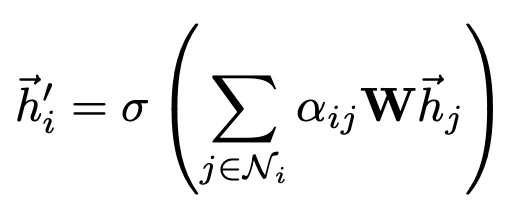

通常使用多头注意力计算，并将每个头的计算结果进行concat或求和操作（一般最后一层注意力层进行求和），计算公式如下：
- （concat操作公式）
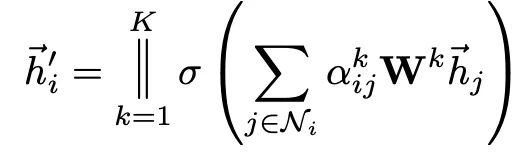

- （求和操作公式一般为最后一层注意力层）
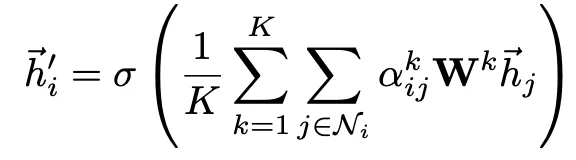
下面贴一段代码可以更直观的看到注意力层是如何并行运算的以及masked的机制是如何实现的，由于官方代码是用tensorflow构建的，因此找了一个第三方写的代码段，内容来自：https://blog.csdn.net/weixin_43476533/article/details/107229242

```python
    def forward(self, input, adj):
        h = torch.mm(input, self.W)
        #print(h.shape)  torch.Size([2708, 8]) 8是label的个数
        N = h.size()[0]
        #print(N)  2708 nodes的个数
        
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)#见下图
        #print(a_input.shape)  torch.Size([2708, 2708, 16])
        
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))   #即论文里的eij
        #squeeze除去维数为1的维度
        #[2708, 2708, 16]与[16, 1]相乘再除去维数为1的维度，故其维度为[2708,2708],与领接矩阵adj的维度一样

        zero_vec = -9e15*torch.ones_like(e)
        #维度大小与e相同，所有元素都是-9*10的15次方
        
        attention = torch.where(adj > 0, e, zero_vec)
        '''这里我们回想一下在utils.py里adj怎么建成的：两个节点有边，则为1，否则为0。
        故adj的领接矩阵的大小为[2708,2708]。(不熟的自己去复习一下图结构中的领接矩阵)。
        故当adj>0，即两结点有边，则用gat构建的矩阵e，若adj=0,则另其为一个很大的负数，这么做的原因是进行softmax时，这些数就会接近于0了。
       
        '''
        attention = F.softmax(attention, dim=1)
        #对应论文公式3，attention就是公式里的αij
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'
```
可以看到这里直接是完全并行计算再根据邻接矩阵（添加自循环）计算mask，大于0的表示一阶邻居节点，等于0的表示不直接相连的节点，按常规操作添加一个大数进行softmax置零操作。

### 3、模型结果：
该图注意力模型分别在transductive的任务中的Cora、Citeseer、Pubmed citation数据集和Inductive任务中的PPI数据集上F1-score都取得了SOTA的成绩。此外为了验证自主意力的有效性，作者还使用了所有注意力分数置为1的模型以作对照，证明了使用注意力机制的模型效果更好比不使用提高了3.9个点（PPI数据集）。

### 4、总结：
该图神经网络模型合理的使用了注意力机制，能够更加的融合和学习到邻居节点之间的信息，该模型优点是允许（隐式地）在处理不同大小的邻域时，将不同的重要性分配给邻域中的不同节点，不依赖于预先了解整个图形结构，从而解决了以前基于光谱的方法的许多理论问题。在我个人看来该模型还有一些不足，这里只是对一阶邻居做了注意力，整个节点融合的信息多数只来自于一阶邻居（虽然随着层数的加深一个节点有融合全局信息的潜力）这是一个很强的归纳偏置，对模型学习到真个图结构的全局信息的能力有限，作者也只是做了节点分类任务的测试并没有做整个图结构分类任务的测试相比对此也是信心不足把，接下来的工作我想尝试构造一个全局的图注意力模型，希望能够对现有模型进行改进。